In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Black-Scholes formula for option pricing
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied volatility function
def implied_volatility(option_price, S, K, T, r, option_type='call'):
    def objective_function(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - option_price
    try:
        return brentq(objective_function, 1e-5, 5)
    except ValueError:
        return np.nan

# Parameters
strike_prices = [5620, 5640, 5660, 5680, 5700, 5720, 5740, 5760, 5780, 5800]
risk_free_rate = 0.0430  # 4.30%
current_date = datetime(2024, 10, 28)
expiry_dates = [current_date + timedelta(days=i) for i in range(10)]
S = 5808.0  # Last known SPX price

# Load option values
call_values_df = pd.read_csv('american_call_values.csv')
put_values_df = pd.read_csv('american_put_values.csv')

# Calculate implied volatilities
implied_vols = {'Expiry': [], 'Strike': [], 'Call_IV': [], 'Put_IV': []}

for expiry_date in expiry_dates:
    T = (expiry_date - current_date).days / 365.0
    for strike in strike_prices:
        call_column = f'Call_{strike}'
        put_column = f'Put_{strike}'
        if call_column in call_values_df.columns and put_column in put_values_df.columns:
            call_price = call_values_df[call_column].mean()
            put_price = put_values_df[put_column].mean()
            call_iv = implied_volatility(call_price, S, strike, T, risk_free_rate, 'call')
            put_iv = implied_volatility(put_price, S, strike, T, risk_free_rate, 'put')
            implied_vols['Expiry'].append(expiry_date.strftime('%Y-%m-%d'))
            implied_vols['Strike'].append(strike)
            implied_vols['Call_IV'].append(call_iv)
            implied_vols['Put_IV'].append(put_iv)

# Convert to DataFrame
implied_vols_df = pd.DataFrame(implied_vols)

# Save to CSV
implied_vols_df.to_csv('implied_volatilities.csv', index=False)
print("Implied volatilities saved to 'implied_volatilities.csv'.")


Implied volatilities saved to 'implied_volatilities.csv'.


/var/folders/jp/82zjtkm90vgbycmw30_2kztm0000gn/T/ipykernel_15595/4003386838.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [2]:
# Replace near-zero Put_IV values with NaN to handle them consistently
implied_vols_df['Put_IV'] = implied_vols_df['Put_IV'].apply(lambda x: x if x > 0.0001 else None)

# Perform interpolation for both Call_IV and Put_IV
implied_vols_df['Call_IV'] = implied_vols_df['Call_IV'].interpolate(method='linear', limit_direction='both')
implied_vols_df['Put_IV'] = implied_vols_df['Put_IV'].interpolate(method='linear', limit_direction='both')

# Check for remaining missing values after interpolation
missing_after_interpolation = implied_vols_df.isna().sum()
print("\nMissing values after interpolation:")
print(missing_after_interpolation)

# Optionally drop rows with any remaining missing values if necessary
implied_vols_df.dropna(inplace=True)

# Save the final cleaned dataset
implied_vols_df.to_csv('implied_volatilities_final_cleaned.csv', index=False)
print("\nFinal cleaned implied volatilities saved to 'implied_volatilities_final_cleaned.csv'.")



Missing values after interpolation:
Expiry     0
Strike     0
Call_IV    0
Put_IV     0
dtype: int64

Final cleaned implied volatilities saved to 'implied_volatilities_final_cleaned.csv'.


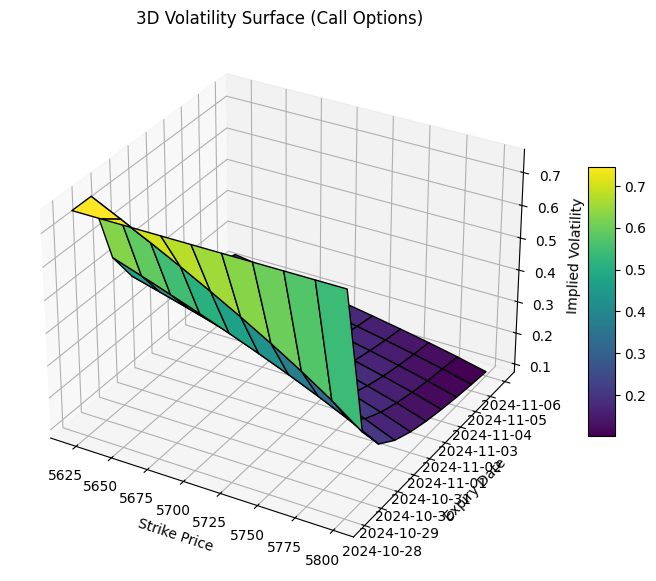

In [3]:


# Load the cleaned implied volatilities data
vol_data = pd.read_csv('implied_volatilities_final_cleaned.csv')
# Prepare the data for 3D plotting (Call Options example)
vol_surface_call = vol_data.pivot(index='Expiry', columns='Strike', values='Call_IV')

# Extract axes values
X = vol_surface_call.columns.values  # Strike Prices
Y = pd.to_datetime(vol_surface_call.index).map(lambda x: x.toordinal())  # Expiry Dates as ordinal
X, Y = np.meshgrid(X, Y)  # Create a meshgrid
Z = vol_surface_call.values  # Implied Volatilities

# Plot the 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')

# Map the ordinal Y-axis back to actual dates for labeling
y_labels = pd.to_datetime(vol_surface_call.index)  # Original expiry dates
ax.set_yticks(y_labels.map(lambda x: x.toordinal()))  # Set ticks to ordinal values
ax.set_yticklabels(y_labels.strftime('%Y-%m-%d'))  # Label ticks with formatted dates

# Add labels and title
ax.set_title('3D Volatility Surface (Call Options)')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Expiry Date')
ax.set_zlabel('Implied Volatility')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()


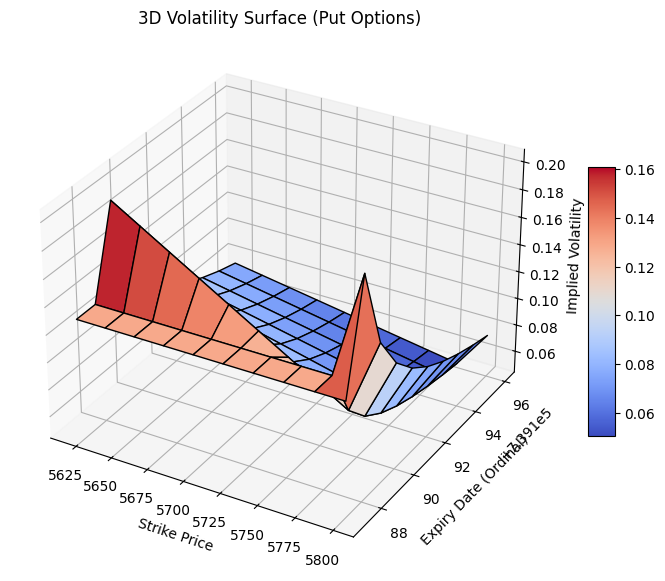

In [4]:
# Prepare the data for 3D plotting (Put Options)
vol_surface_put = vol_data.pivot(index='Expiry', columns='Strike', values='Put_IV')

# Extract axes values for Put Options
X_put = vol_surface_put.columns.values  # Strike Prices
Y_put = pd.to_datetime(vol_surface_put.index).map(lambda x: x.toordinal())  # Expiry Dates as ordinal
X_put, Y_put = np.meshgrid(X_put, Y_put)  # Create a meshgrid
Z_put = vol_surface_put.values  # Implied Volatilities

# Plot the 3D surface for Put Options
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf_put = ax.plot_surface(X_put, Y_put, Z_put, cmap='coolwarm', edgecolor='k')

# Add labels and title
ax.set_title('3D Volatility Surface (Put Options)')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Expiry Date (Ordinal)')
ax.set_zlabel('Implied Volatility')

# Add a color bar for the surface plot
fig.colorbar(surf_put, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()
